<div style="display: flex; background-color: RGB(255,114,0);" >

# PROJET - Bonheur World </h1>
</div>

<div style="display: flex; background-color: Blue; padding: 15px;" >

# 1.Mission 
</div>

Dans cette étude de cas, nous formerons un algorithme d'apprentissage automatique non supervisé pour regrouper les pays en fonction de caractéristiques telles que la production économique, le soutien social, l'espérance de vie, la liberté, l'absence de corruption et la générosité. Le Rapport sur le bonheur dans le monde détermine l'état du bonheur mondial. Les scores de bonheur et les données de classement ont été collectés en demandant aux individus de classer leur vie de 0 (la pire vie possible) à 10 (la meilleure vie possible).         

- Un notebook contenant les fonctions permettant le prétraitement des données ainsi que les résultats du clustering (en y incluant des représentations graphiques) ....
- Un support de présentation qui présente la démarche et les résultats du clustering.

In [1]:
from os import getcwd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from tqdm import tqdm
from bonheur_bed_ara import *

<div style="display: flex; background-color: Blue; padding: 15px;" >

# 2.Chargement des données
</div>

In [2]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
force_reloading = True

# Récupère le répertoire du programme
file_path = getcwd() + "\\"
data_set_path = file_path + "dataset\\"
print(f"Current execution path : {file_path}")
print(f"Dataset path : {data_set_path}")

Current execution path : c:\Users\User\WORK\workspace-ia\PROJETS\projet_bonheur_bed\
Dataset path : c:\Users\User\WORK\workspace-ia\PROJETS\projet_bonheur_bed\dataset\


In [11]:
pays_file_name = "data_set_countries_clean.csv"

df_pays_origin = pd.read_csv(data_set_path+pays_file_name, sep=',')
df_pays_origin = df_pays_origin.sort_values(by="country")

print(f"{df_pays_origin.shape} données chargées ------> {list(df_pays_origin.columns)}")
df_pays_origin.head()

(211, 8) données chargées ------> ['id', 'alpha3', 'alpha2', 'country', 'country_official', 'continent_code', 'latitude', 'longitude']


,id,alpha3,alpha2,country,country_official,continent_code,latitude,longitude
0,4.0,AFG,AF,Afghanistan,Islamic Republic of Afghanistan,AS,29.276770,42.274721
2,8.0,ALB,AL,Albania,Republic of Albania,EU,21.483333,36.066667
45,12.0,DZA,DZ,Algeria,People's Democratic Republic of Algeria,AF,14.349729,43.892024
1,24.0,AGO,AO,Angola,Republic of Angola,AF,41.795972,12.235112
6,10.0,ATA,AQ,Antarctica,Antarctica,NaN,-22.016981,-47.920533


In [12]:
data_evolution_name = "evolution_score_altasocio_2022-03-31.csv"
df_evolution_orgin = pd.read_csv(data_set_path+data_evolution_name, sep=',')
df_evolution_orgin = df_evolution_orgin.rename(columns={"pays":"country"})
df_evolution_orgin = df_evolution_orgin.sort_values(by="country")

print(f"{df_evolution_orgin.shape} données chargées ------> {list(df_evolution_orgin.columns)}")
df_evolution_orgin.head()

(165, 8) données chargées ------> ['country', 'score_2015', 'score_2016', 'score_2017', 'score_2018', 'score_2019', 'score_2020', 'country_official']


,country,score_2015,score_2016,score_2017,score_2018,score_2019,score_2020,country_official
164,Afghanistan,"3,575","3,360","3,794","3,632","3,203","2,567",Islamic Republic of Afghanistan
115,Afrique du Sud,"4,642","4,459","4,829","4,724","4,722","4,814",Republic of South Africa
111,Albanie,"4,959","4,655","4,644","4,586","4,719","4,883",Republic of Albania
106,Algérie,"5,605","6,355","5,872","5,295","5,211","5,005",People's Democratic Republic of Algeria
16,Allemagne,"6,750","6,994","6,951","6,965","6,985","7,076",Federal Republic of Germany


In [3]:
score_dataset_filenames = []
score_rapport_with ="Rapport-bonheur-"

world_datas_files = []
world_start_with ="world_"

# récupération données
extensions = [".csv", ".xls"]

for ext in extensions:
    score_dataset_filenames.extend(get_dir_files(data_set_path, start_with=score_rapport_with , endwith=ext))
    world_datas_files.extend(get_dir_files(data_set_path, start_with=world_start_with , endwith=ext))

print(f"{len(score_dataset_filenames)} Fichiers score à traiter et {len(world_datas_files)} Fichiers monde à traiter")

4 Fichiers score à tariter et 18 Fichiers monde à traiter


In [58]:
df_origine = None
df_origine_by_line = None

country_col_name = "country"

sizes = []


for score_file_name in tqdm(score_dataset_filenames):
    year = score_file_name.replace(score_rapport_with,"")
    year = year.split(".")[0].strip()

    df_temp = pd.read_csv(data_set_path+score_file_name, sep=',')
    df_temp = df_temp.sort_values(by=country_col_name)

    df_temp[country_col_name] = df_temp[country_col_name].str.replace("*", "", regex=False)
    df_temp[country_col_name] = df_temp[country_col_name].str.strip()

    df_temp2 = df_temp.copy()

    initial_columns_name = list(df_temp.columns)

    for col in initial_columns_name:
        if "Explained by:" in col:
            df_temp = df_temp.drop(col, axis=1)
            df_temp2 = df_temp2.drop(col, axis=1)
        elif "ladder" in col.lower():
            df_temp = df_temp.drop(col, axis=1)
            df_temp2 = df_temp2.drop(col, axis=1)
        else:
            if "residual" in col:
                df_temp = df_temp.rename(columns={col:'Dystopia + residual'})
                df_temp2 = df_temp2.rename(columns={col:'Dystopia + residual'})
                col = 'Dystopia + residual'
            elif "whisker"  in col.lower() and "low"  in col.lower():
                df_temp = df_temp.rename(columns={col:'Whisker-low'})
                df_temp2 = df_temp2.rename(columns={col:'Whisker-low'})
                col = 'Whisker-low'
            elif "whisker"  in col.lower() and "upper"  in col.lower():
                df_temp = df_temp.rename(columns={col:'Whisker-high'})
                df_temp2 = df_temp2.rename(columns={col:'Whisker-high'})
                col = 'Whisker-high'

            if year not in col and country_col_name != col:
                df_temp = df_temp.rename(columns={col:year+"-"+col})
            elif col != year:
                df_temp2 = df_temp2.rename(columns={col:col.replace(year+"-", "")})
            elif col == year:
                df_temp2 = df_temp2.rename(columns={col:"score"})

    df_temp2["year"] = year
    if df_origine is None:
        df_origine = df_temp
        df_origine_by_line = df_temp2
        
    else:
        df_origine = df_origine.merge(df_temp, on=country_col_name, how="outer", indicator=True)
        df_origine = df_origine.rename(columns={"_merge":year+"_merge"})

        df_origine_by_line = pd.concat([df_origine_by_line,df_temp2], axis=0)
        
    sizes.append(f"{score_file_name} CURRENT : {df_temp.shape}  ==> : {df_origine.shape} ==> {df_origine_by_line.shape}")

df_origine_by_line = df_origine_by_line.sort_values(by=country_col_name)
df_origine = df_origine.sort_values(by=country_col_name)

for line in sizes:
    print(f"{line}")
df_origine.head()

100%|██████████| 4/4 [00:00<00:00, 30.24it/s]

Rapport-bonheur-2019.csv CURRENT : (156, 9)  ==> : (156, 9) ==> (156, 10)
Rapport-bonheur-2020.csv CURRENT : (153, 12)  ==> : (162, 21) ==> (309, 14)
Rapport-bonheur-2021.csv CURRENT : (149, 12)  ==> : (162, 33) ==> (458, 14)
Rapport-bonheur-2022.csv CURRENT : (146, 12)  ==> : (165, 45) ==> (604, 14)


,2019-rank,country,2019,2019-PIB,2019-Soutien,2019-Esperance vie BS,2019-Liberte des choix de vie,2019-Generosite,2019-Corruption,2020-Regional indicator,...,2022-Whisker-high,2022-Whisker-low,2022-Dystopia + residual,2022-PIB,2022-Soutien,2022-Esperance vie BS,2022-Liberte des choix de vie,2022-Generosite,2022-Corruption,2022_merge
0,154.0,Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025,South Asia,...,"2,469","2,339","1,263","0,758",0,"0,289",0,"0,089","0,005",both
1,107.0,Albania,4.719,0.947,0.848,0.874,0.383,0.178,0.027,Central and Eastern Europe,...,"5,321","5,076","1,718","1,439","0,646","0,719","0,511","0,138","0,028",both
2,88.0,Algeria,5.211,1.002,1.160,0.785,0.086,0.073,0.114,Middle East and North Africa,...,"5,215","5,03","1,744","1,363","0,97","0,643","0,146","0,106","0,15",both
3,47.0,Argentina,6.086,1.092,1.432,0.881,0.471,0.066,0.050,Latin America and Caribbean,...,"6,09","5,844","1,891","1,592","1,102","0,662","0,555","0,081","0,085",both
4,116.0,Armenia,4.559,0.850,1.055,0.815,0.283,0.095,0.064,Commonwealth of Independent States,...,"5,519","5,278","1,654","1,434","0,82","0,668","0,558","0,054","0,21",both


In [59]:
df_origine_by_line.columns

Index(['rank', 'country', 'score', 'PIB', 'Soutien', 'Esperance vie BS',
       'Liberte des choix de vie', 'Generosite', 'Corruption', 'year',
       'Regional indicator', 'Whisker-high', 'Whisker-low',
       'Dystopia + residual'],
      dtype='object')

In [60]:
df_origine.columns

Index(['2019-rank', 'country', '2019', '2019-PIB', '2019-Soutien',
       '2019-Esperance vie BS', '2019-Liberte des choix de vie',
       '2019-Generosite', '2019-Corruption', '2020-Regional indicator', '2020',
       '2020-Whisker-high', '2020-Whisker-low', '2020-PIB', '2020-Soutien',
       '2020-Esperance vie BS', '2020-Liberte des choix de vie',
       '2020-Generosite', '2020-Corruption', '2020-Dystopia + residual',
       '2020_merge', '2021-Regional indicator', '2021', '2021-Whisker-high',
       '2021-Whisker-low', '2021-PIB', '2021-Soutien', '2021-Esperance vie BS',
       '2021-Liberte des choix de vie', '2021-Generosite', '2021-Corruption',
       '2021-Dystopia + residual', '2021_merge', '2022-rank', '2022',
       '2022-Whisker-high', '2022-Whisker-low', '2022-Dystopia + residual',
       '2022-PIB', '2022-Soutien', '2022-Esperance vie BS',
       '2022-Liberte des choix de vie', '2022-Generosite', '2022-Corruption',
       '2022_merge'],
      dtype='object')

In [61]:
df_origine_light = df_origine[['country', '2020-Regional indicator', '2021-Regional indicator', 
        '2019-rank','2022-rank',
        '2019', '2020', '2021', '2022',
        '2019-PIB',  '2020-PIB','2021-PIB','2022-PIB',
        '2019-Soutien','2020-Soutien','2021-Soutien','2022-Soutien',
        '2019-Esperance vie BS', '2020-Esperance vie BS','2021-Esperance vie BS','2022-Esperance vie BS',
        '2019-Liberte des choix de vie','2020-Liberte des choix de vie','2021-Liberte des choix de vie','2022-Liberte des choix de vie',
        '2019-Generosite', '2020-Generosite','2021-Generosite','2022-Generosite', 
        '2019-Corruption', '2020-Corruption','2021-Corruption','2022-Corruption',
        '2020-Whisker-high', '2021-Whisker-high','2022-Whisker-high', 
        '2020-Whisker-low', '2021-Whisker-low','2022-Whisker-low',
        '2020-Dystopia + residual','2021-Dystopia + residual', '2022-Dystopia + residual',
        '2020_merge', '2021_merge','2022_merge']]

In [66]:
# On complète les données
df_origine_light["2020-Regional indicator"] = df_origine_light["2020-Regional indicator"].fillna(df_origine_light["2021-Regional indicator"])
df_origine_light["2021-Regional indicator"] = df_origine_light["2021-Regional indicator"].fillna(df_origine_light["2020-Regional indicator"])

In [71]:
df_origine_light[["2020-Regional indicator","2021-Regional indicator"]].describe(include="all")

,2020-Regional indicator,2021-Regional indicator
count,154,154
unique,10,10
top,Sub-Saharan Africa,Sub-Saharan Africa
freq,39,39


In [63]:
df_origine_light.head()

,country,2020-Regional indicator,2021-Regional indicator,2019-rank,2022-rank,2019,2020,2021,2022,2019-PIB,...,2022-Whisker-high,2020-Whisker-low,2021-Whisker-low,2022-Whisker-low,2020-Dystopia + residual,2021-Dystopia + residual,2022-Dystopia + residual,2020_merge,2021_merge,2022_merge
0,Afghanistan,South Asia,South Asia,154.0,146.0,3.203,"2,56690001487732","2,523","2,404",0.350,...,"2,469","2,5055296421051","2,449","2,339","1,50723564624786","1,895","1,263",both,both,both
1,Albania,Central and Eastern Europe,Central and Eastern Europe,107.0,90.0,4.719,"4,88269996643066","5,117","5,199",0.947,...,"5,321","4,77271318435669","5,001","5,076","1,64089703559876","2,25","1,718",both,both,both
2,Algeria,Middle East and North Africa,Middle East and North Africa,88.0,96.0,5.211,"5,00509977340698","4,887","5,122",1.002,...,"5,215","4,91839742660522","4,783","5,03","1,84081172943115","2,242","1,744",both,both,both
3,Argentina,Latin America and Caribbean,Latin America and Caribbean,47.0,57.0,6.086,"5,97469997406006","5,929","5,967",1.092,...,"6,09","5,86995410919189","5,819","5,844","2,07254099845886","2,461","1,891",both,both,both
4,Armenia,Commonwealth of Independent States,Commonwealth of Independent States,116.0,82.0,4.559,"4,67679977416992","5,283","5,399",0.850,...,"5,519","4,56195306777954","5,168","5,278","1,46816158294678","2,127","1,654",both,both,both


<div style="display: flex; background-color: Green; padding: 7px;" >

## 2.1. Visualisation des données
</div>

<div style="display: flex; background-color: indigo;" >

#### 2.1.1 DF données fournies > 2019
</div>

In [68]:
df_origine.describe(include='all')

,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,156,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
unique,156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Finland,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.407096,0.905147,1.208814,0.725244,0.392571,0.184846,0.110603
std,NaN,1.113120,0.398389,0.299191,0.242124,0.143289,0.095254,0.094538
min,NaN,2.853000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,4.544500,0.602750,1.055750,0.547750,0.308000,0.108750,0.047000
50%,NaN,5.379500,0.960000,1.271500,0.789000,0.417000,0.177500,0.085500
75%,NaN,6.184500,1.232500,1.452500,0.881750,0.507250,0.248250,0.141250


In [69]:
df_origine = df_origine.rename(columns={'Country or region':'country', 
                                        'Score':2019,
                                        'GDP per capita':'2019-PIB', 
                                        'Social support':'2019-Soutien',
                                        'Healthy life expectancy':'2019-Esperance vie BS',
                                        'Freedom to make life choices':'2019-Liberte des choix de vie',
                                        'Generosity':'2019-Generosite',
                                        'Perceptions of corruption':'2019-Corruption'
                                        })
df_origine.columns

Index([                      'country',                            2019,
                            '2019-PIB',                  '2019-Soutien',
               '2019-Esperance vie BS', '2019-Liberte des choix de vie',
                     '2019-Generosite',               '2019-Corruption'],
      dtype='object')

<div style="display: flex; background-color: indigo;" >

#### 2.1.2 DF temporelle
</div>

In [70]:
df_evolution_orgin.head()

,pays,score_2015,score_2016,score_2017,score_2018,score_2019,score_2020
0,Finlande,"7,406","7,413","7,469","7,632","7,769","7,809"
1,Danemark,"7,527","7,526","7,522","7,555","7,600","7,646"
2,Suisse,"7,587","7,509","7,494","7,487","7,480","7,560"
3,Islande,"7,561","7,501","7,504","7,495","7,494","7,504"
4,Norvège,"7,522","7,498","7,537","7,594","7,554","7,488"


In [72]:
df_evolution_orgin = df_evolution_orgin.rename(columns={"pays":"country"})
df_evolution_orgin.columns

Index(['country', 'score_2015', 'score_2016', 'score_2017', 'score_2018',
       'score_2019', 'score_2020'],
      dtype='object')

In [73]:
df_evolution_orgin.describe(include="all")

,country,score_2015,score_2016,score_2017,score_2018,score_2019,score_2020
count,165,158,157,155,156,156,153
unique,165,156,154,151,154,155,150
top,Finlande,"5,192","3,739","5,838","5,483","5,208","5,546"
freq,1,2,2,2,2,2,2


<div style="display: flex; background-color: indigo;" >

#### 2.1.3 DF données pays
</div>

In [74]:
df_pays_origin = df_pays_origin.rename(columns={"id":"id_country", 'country_official':'official_name'})
df_pays_origin.columns

Index(['id_country', 'alpha3', 'alpha2', 'country', 'official_name',
       'continent_code', 'latitude', 'longitude'],
      dtype='object')

In [75]:
print(df_pays_origin.shape)
df_pays_origin.describe(include="all")

(177, 8)


,id_country,alpha3,alpha2,country,official_name,continent_code,latitude,longitude
count,172.000000,177,175,177,176,154,168.000000,168.000000
unique,NaN,174,173,177,174,5,NaN,NaN
top,NaN,-99,SO,Kosovo,Federal Republic of Somalia,AF,NaN,NaN
freq,NaN,4,2,1,2,50,NaN,NaN
mean,419.970930,NaN,NaN,NaN,NaN,NaN,27.172085,25.755675
std,252.540783,NaN,NaN,NaN,NaN,NaN,22.795738,58.878679
min,4.000000,NaN,NaN,NaN,NaN,NaN,-41.333167,-117.182229
25%,207.000000,NaN,NaN,NaN,NaN,NaN,14.119527,1.580598
50%,409.000000,NaN,NaN,NaN,NaN,NaN,34.107350,23.602495
75%,627.000000,NaN,NaN,NaN,NaN,NaN,45.511673,46.696418


<div style="display: flex; background-color: Green; padding: 7px;" >

## 2.2. Fusion des DF
</div>

<div style="display: flex; background-color: indigo;" >

#### 2.2.1. Fusion dataset source et données temporelles
</div>

In [76]:
print(f"ORIGIN : {df_origine.shape}, {df_evolution_orgin.shape}, AFTER ", end="")
df_global = df_origine.merge(df_evolution_orgin, on='country', how="outer", indicator=True)
print(df_global.shape)
df_global.head()

ORIGIN : (156, 8), (165, 7), AFTER (279, 15)


,country,2019,2019-PIB,2019-Soutien,2019-Esperance vie BS,2019-Liberte des choix de vie,2019-Generosite,2019-Corruption,score_2015,score_2016,score_2017,score_2018,score_2019,score_2020,_merge
0,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [77]:
df_global[df_global["_merge"]!="both"]

,country,2019,2019-PIB,2019-Soutien,2019-Esperance vie BS,2019-Liberte des choix de vie,2019-Generosite,2019-Corruption,score_2015,score_2016,score_2017,score_2018,score_2019,score_2020,_merge
0,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,Yémen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,077","3,724","3,593","3,355","3,380","3,527",right_only
275,Tanzanie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,781","3,666","3,349","3,303","3,231","3,476",right_only
276,Centrafrique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,678",NaN,"2,693","3,083","3,083","3,476",right_only
277,Syrie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,006","3,069","3,462","3,462","3,462",NaN,right_only


<div style="display: flex; background-color: indigo;" >

#### 2.2.2. Fusion dataset intermédiaire et données pays
</div>

In [47]:
print(f"ORIGIN : {df_origine.shape}, {df_pays_origin.shape}, AFTER ", end="")
df_global = df_origine.merge(df_pays_origin, on='country', how="left", indicator=True)
print(df_global.shape)
df_global.head()

ORIGIN : (156, 8), (177, 8), AFTER (156, 16)


,country,2019,2019-GDP per capita,2019-Social support,2019-Healthy life expectancy,2019-Freedom to make life choices,2019-Generosity,2019-Perceptions of corruption,id_country,alpha3,alpha2,official_name,continent_code,latitude,longitude,_merge
0,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393,246.0,FIN,FI,Republic of Finland,EU,61.924110,25.748151,both
1,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410,208.0,DNK,DK,Kingdom of Denmark,EU,1.288895,103.846500,both
2,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341,578.0,NOR,NO,Kingdom of Norway,EU,52.650280,-7.249520,both
3,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118,352.0,ISL,IS,Republic of Iceland,EU,-27.148133,-109.334378,both
4,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298,528.0,NLD,NL,Kingdom of the Netherlands,EU,25.665091,94.076387,both


In [40]:
df_global[df_global["_merge"]!="both"]

,country,2019,2019-GDP per capita,2019-Social support,2019-Healthy life expectancy,2019-Freedom to make life choices,2019-Generosity,2019-Perceptions of corruption,id_country,alpha3,alpha2,official_name,continent_code,latitude,longitude,_merge
21,Malta,6.726,1.300,1.520,0.999,0.564,0.375,0.151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
33,Singapore,6.262,1.572,1.463,1.141,0.556,0.271,0.453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
36,Bahrain,6.199,1.362,1.368,0.871,0.536,0.255,0.110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
56,Mauritius,5.888,1.120,1.402,0.798,0.498,0.215,0.060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
75,Hong Kong,5.430,1.438,1.277,1.122,0.440,0.258,0.287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
141,Comoros,3.973,0.274,0.757,0.505,0.142,0.275,0.078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


<div style="display: flex; background-color: Blue; padding: 15px;" >

# 3.Exploration des données
</div>

<div style="display: flex; background-color: green;" >

## 1.1. Visualisation des données
</div>


In [4]:
df_origine.shape

(156, 8)

In [5]:
df_origine.head()

,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
Overall rank,,,,,,,,
1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


In [6]:
df_origine.dtypes

Country or region                object
Score                           float64
GDP per capita                  float64
Social support                  float64
Healthy life expectancy         float64
Freedom to make life choices    float64
Generosity                      float64
Perceptions of corruption       float64
dtype: object

In [7]:
df_origine.describe()

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,5.407096,0.905147,1.208814,0.725244,0.392571,0.184846,0.110603
std,1.113120,0.398389,0.299191,0.242124,0.143289,0.095254,0.094538
min,2.853000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.544500,0.602750,1.055750,0.547750,0.308000,0.108750,0.047000
50%,5.379500,0.960000,1.271500,0.789000,0.417000,0.177500,0.085500
75%,6.184500,1.232500,1.452500,0.881750,0.507250,0.248250,0.141250
max,7.769000,1.684000,1.624000,1.141000,0.631000,0.566000,0.453000


array([[<AxesSubplot:title={'center':'Score'}>,
        <AxesSubplot:title={'center':'GDP per capita'}>,
        <AxesSubplot:title={'center':'Social support'}>],
       [<AxesSubplot:title={'center':'Healthy life expectancy'}>,
        <AxesSubplot:title={'center':'Freedom to make life choices'}>,
        <AxesSubplot:title={'center':'Generosity'}>],
       [<AxesSubplot:title={'center':'Perceptions of corruption'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

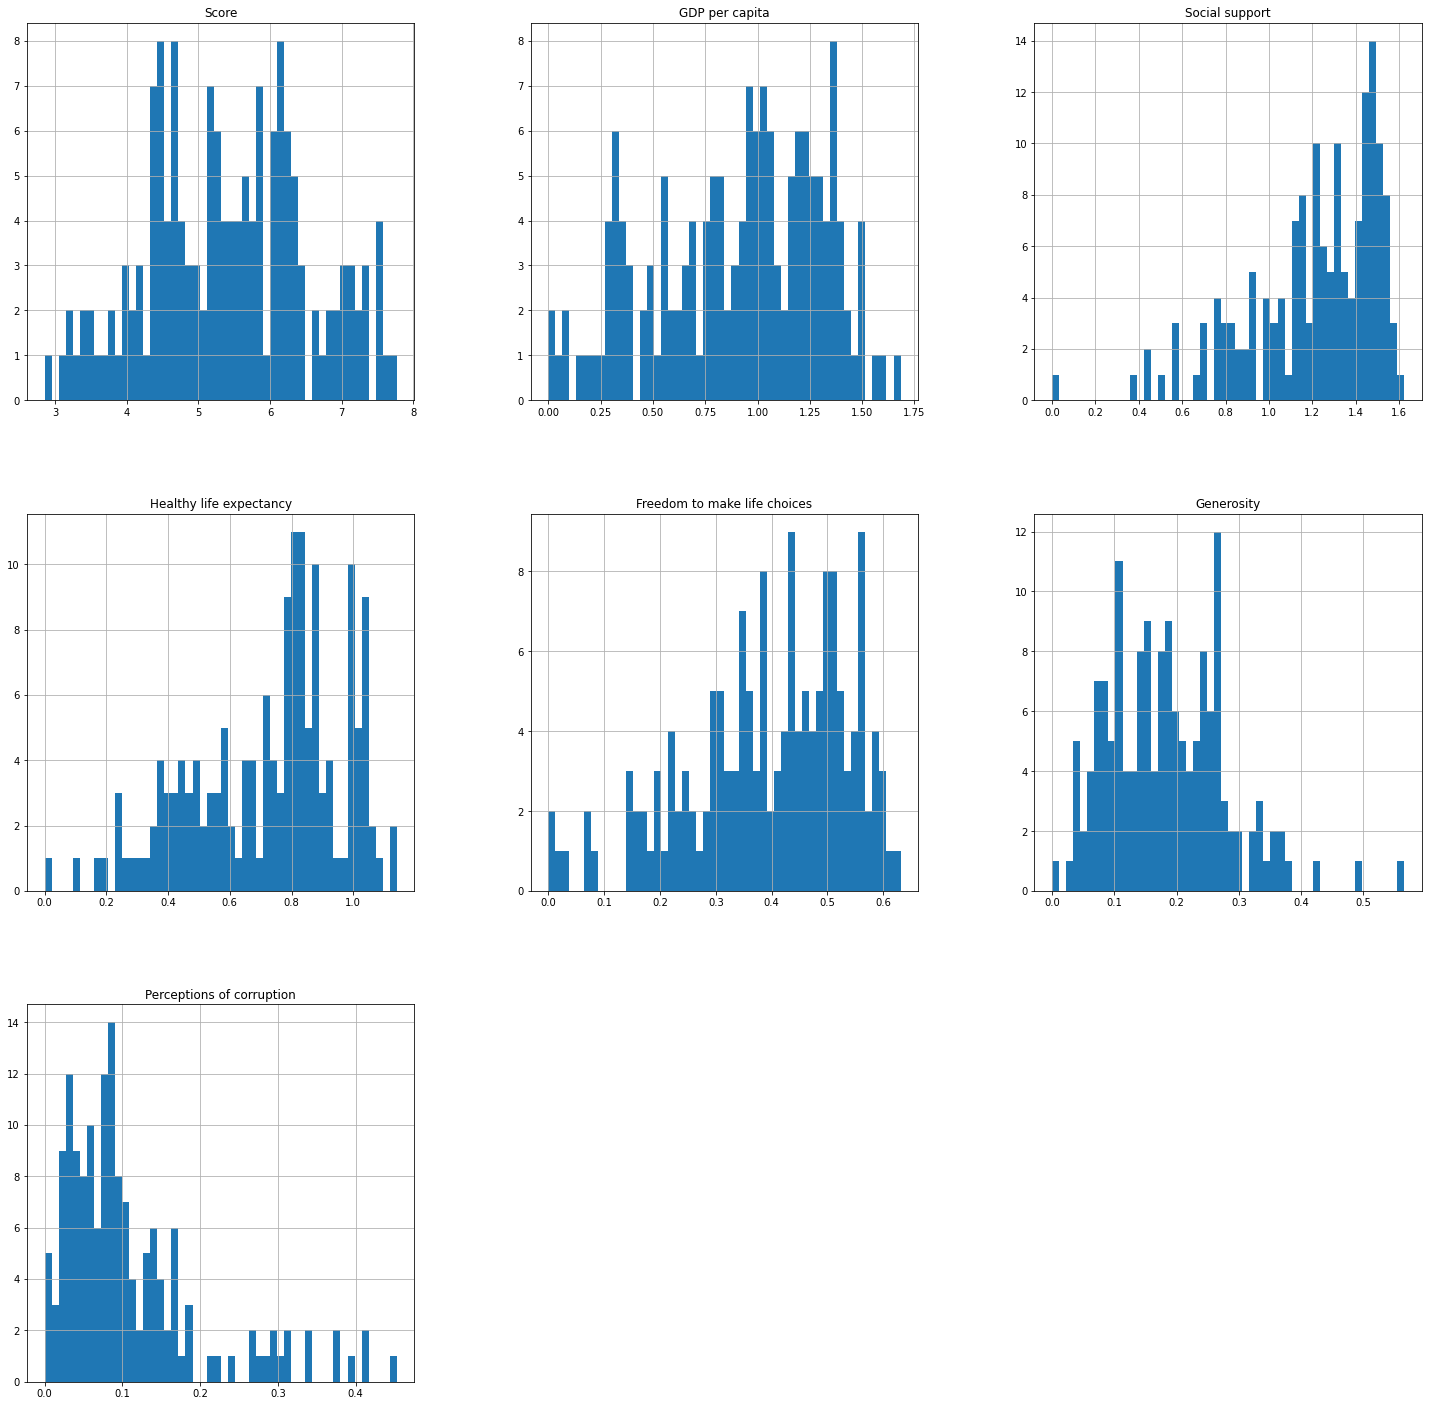

In [8]:
df_origine.hist(figsize=(25,25),bins=50)

<div style="display: flex; background-color: green;" >

## 1.2. Analyse des NaN
</div>


<AxesSubplot:ylabel='Overall rank'>

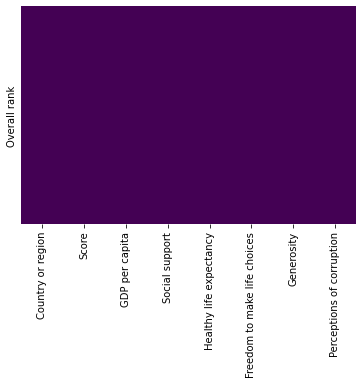

In [9]:
sns.heatmap(df_origine.isnull(), yticklabels=False,cbar=False, cmap='viridis')

C:\Program Files\Python39\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\Program Files\Python39\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<AxesSubplot:>

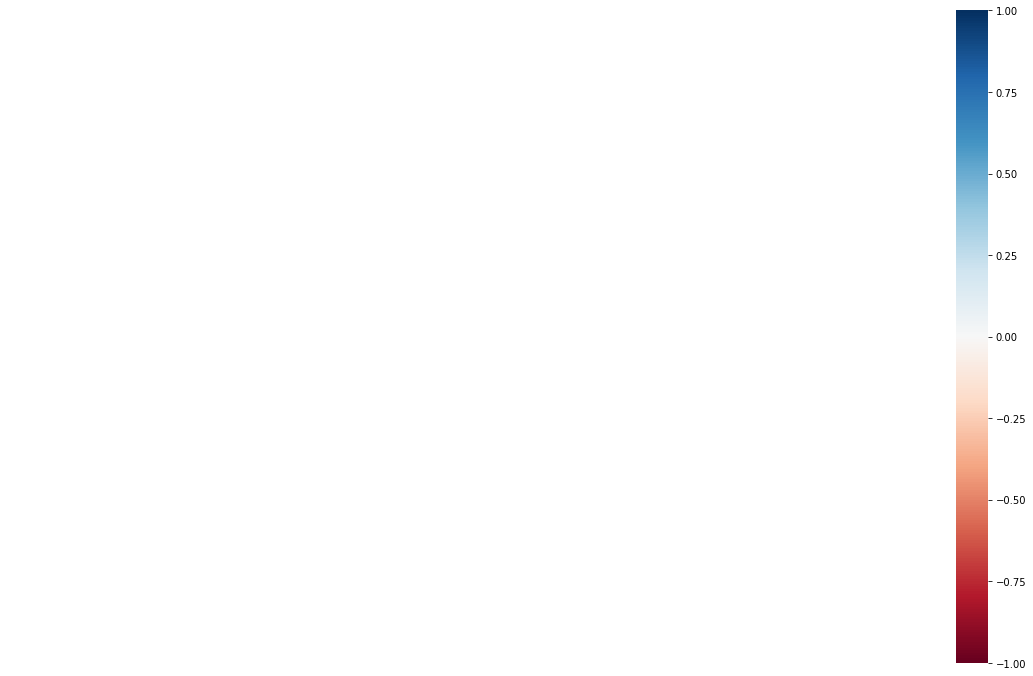

In [10]:
msno.heatmap(df_origine)

<AxesSubplot:>

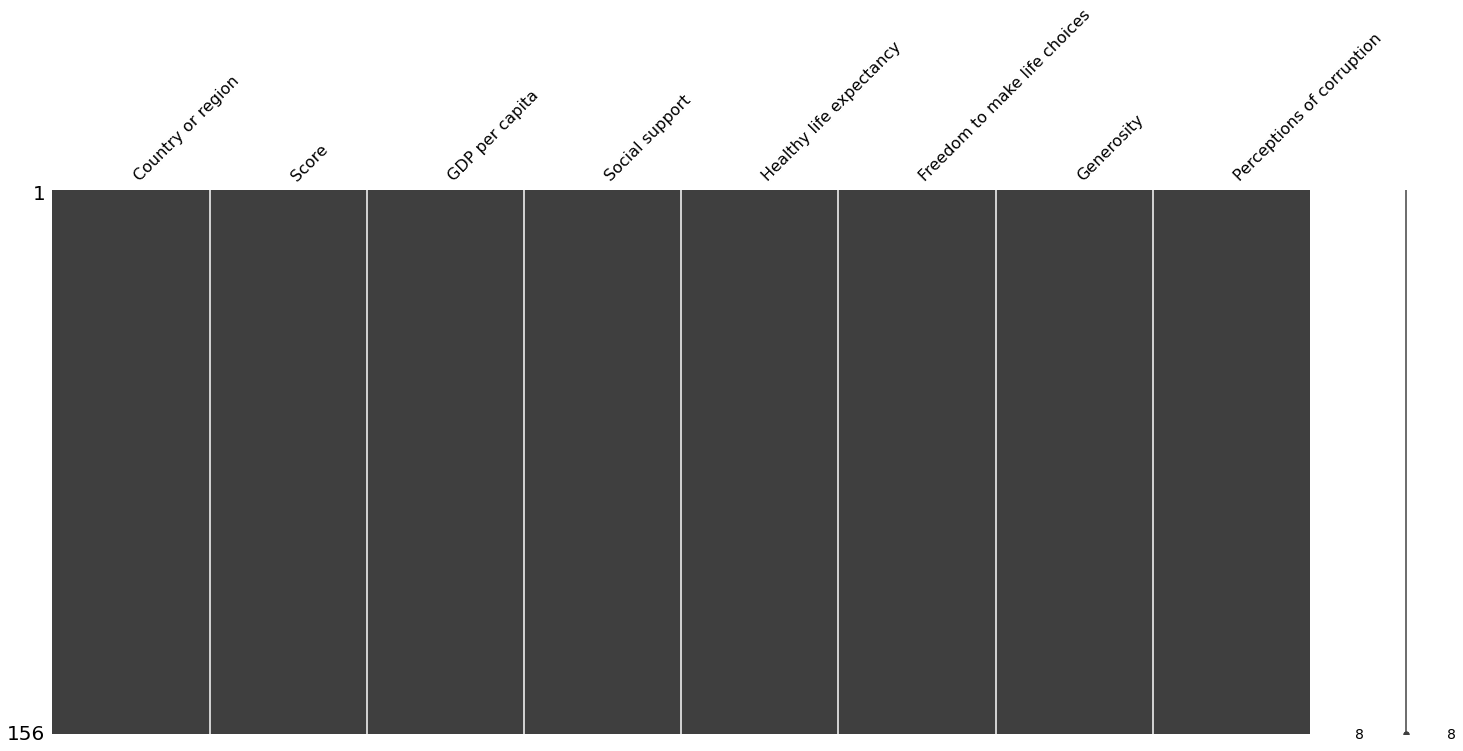

In [11]:
# Avant nettoyage
msno.matrix(df_origine)

<AxesSubplot:>

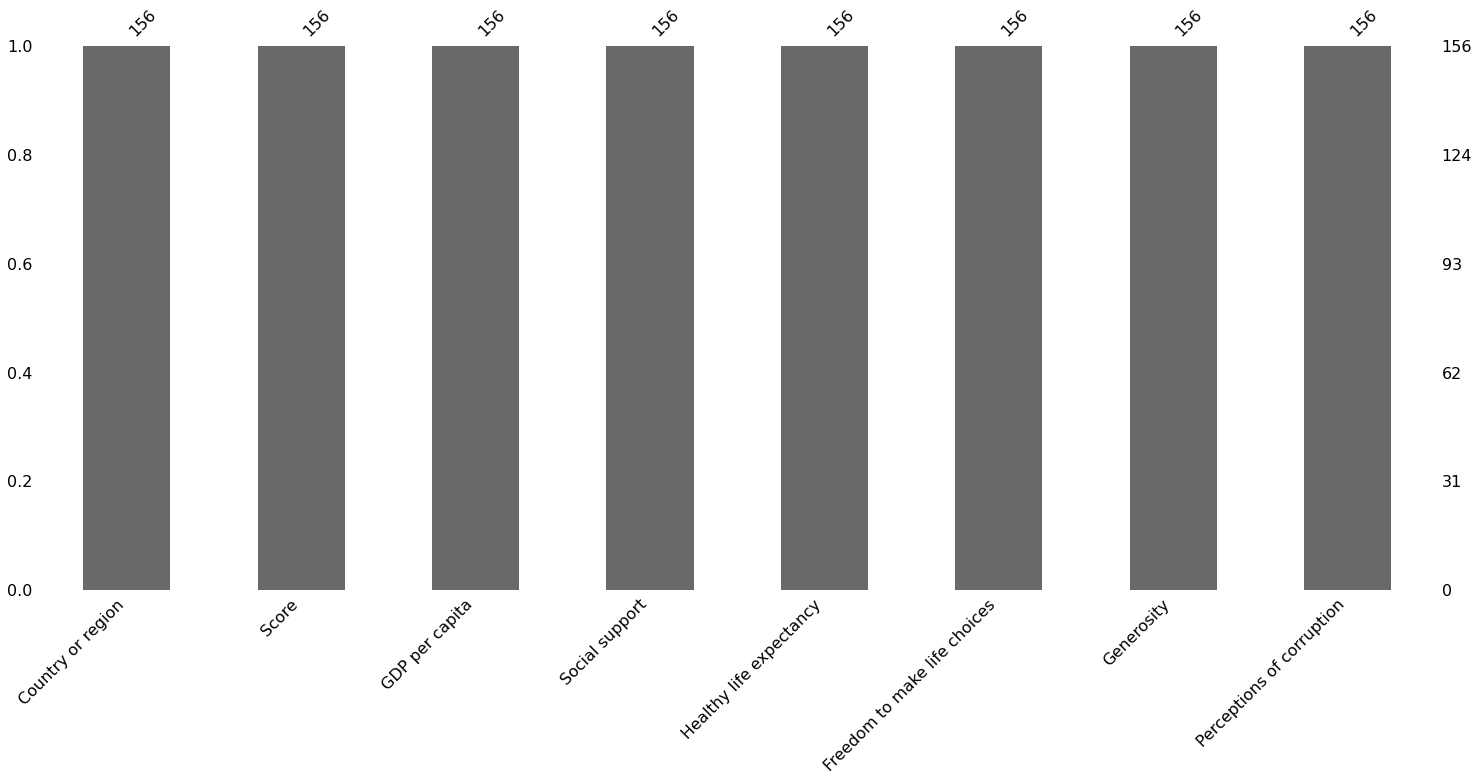

In [12]:
msno.bar(df_origine)

<div style="display: flex; background-color: green;" >

## 1.2. Corrélations entre les données
</div>


In [13]:
df_origine["score_int"] = round(df_origine["Score"])
df_origine["score_int"] = df_origine["score_int"].astype('int')

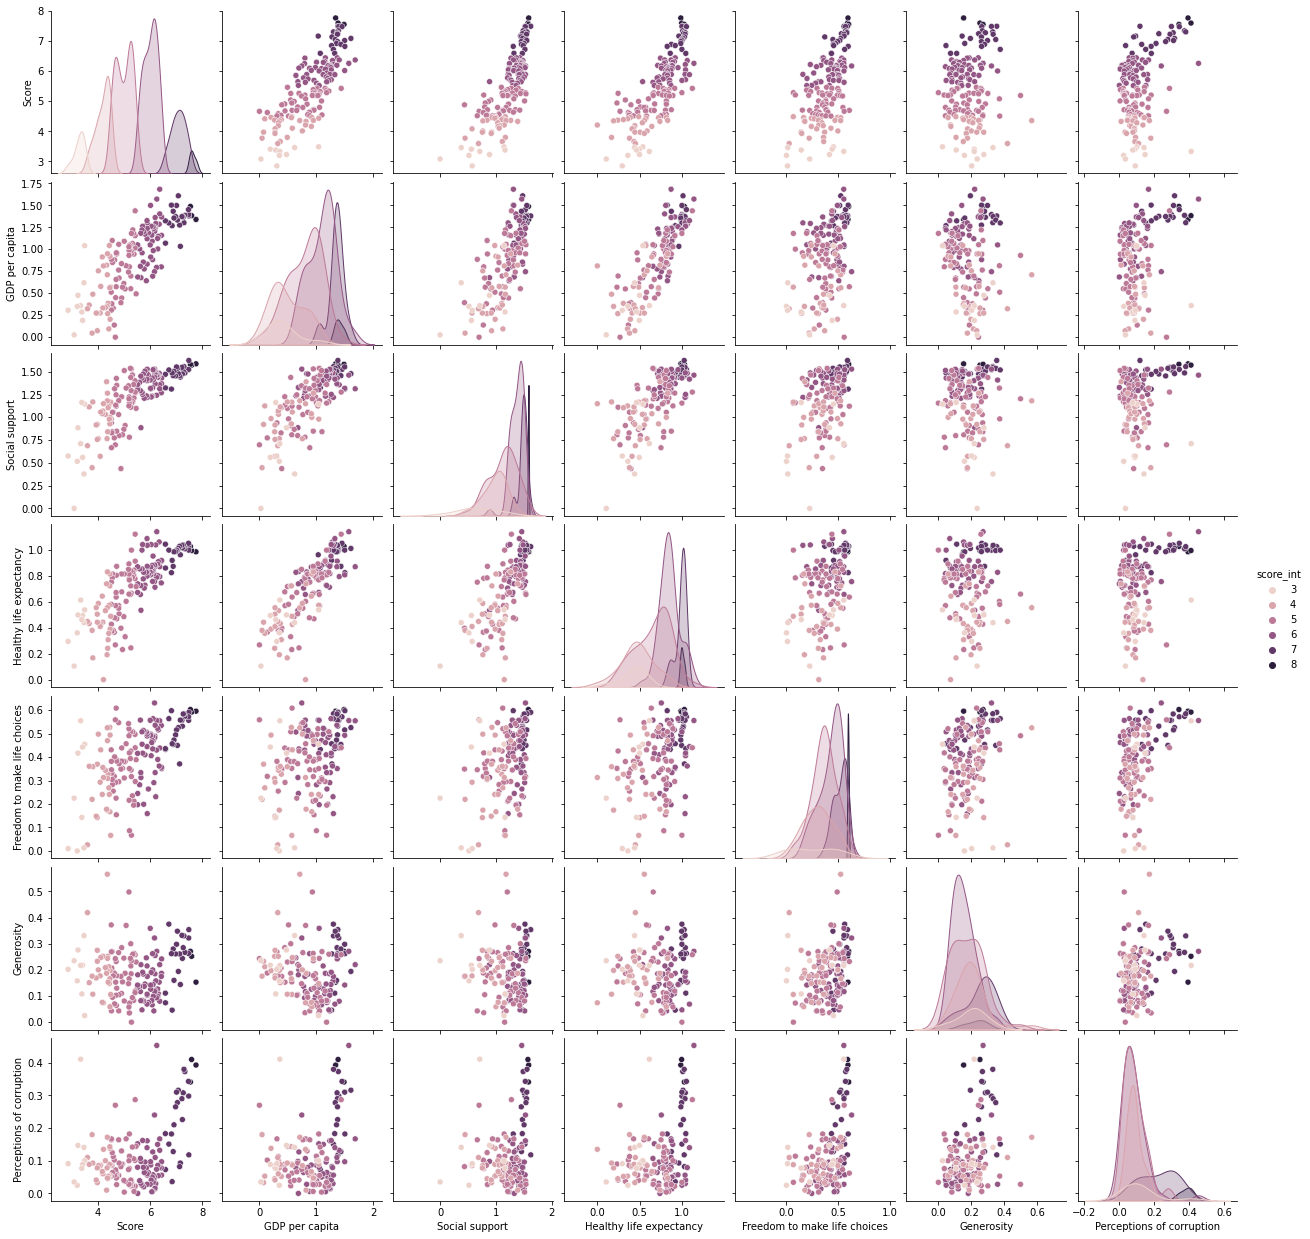

In [14]:
sns.pairplot(df_origine, hue="score_int")

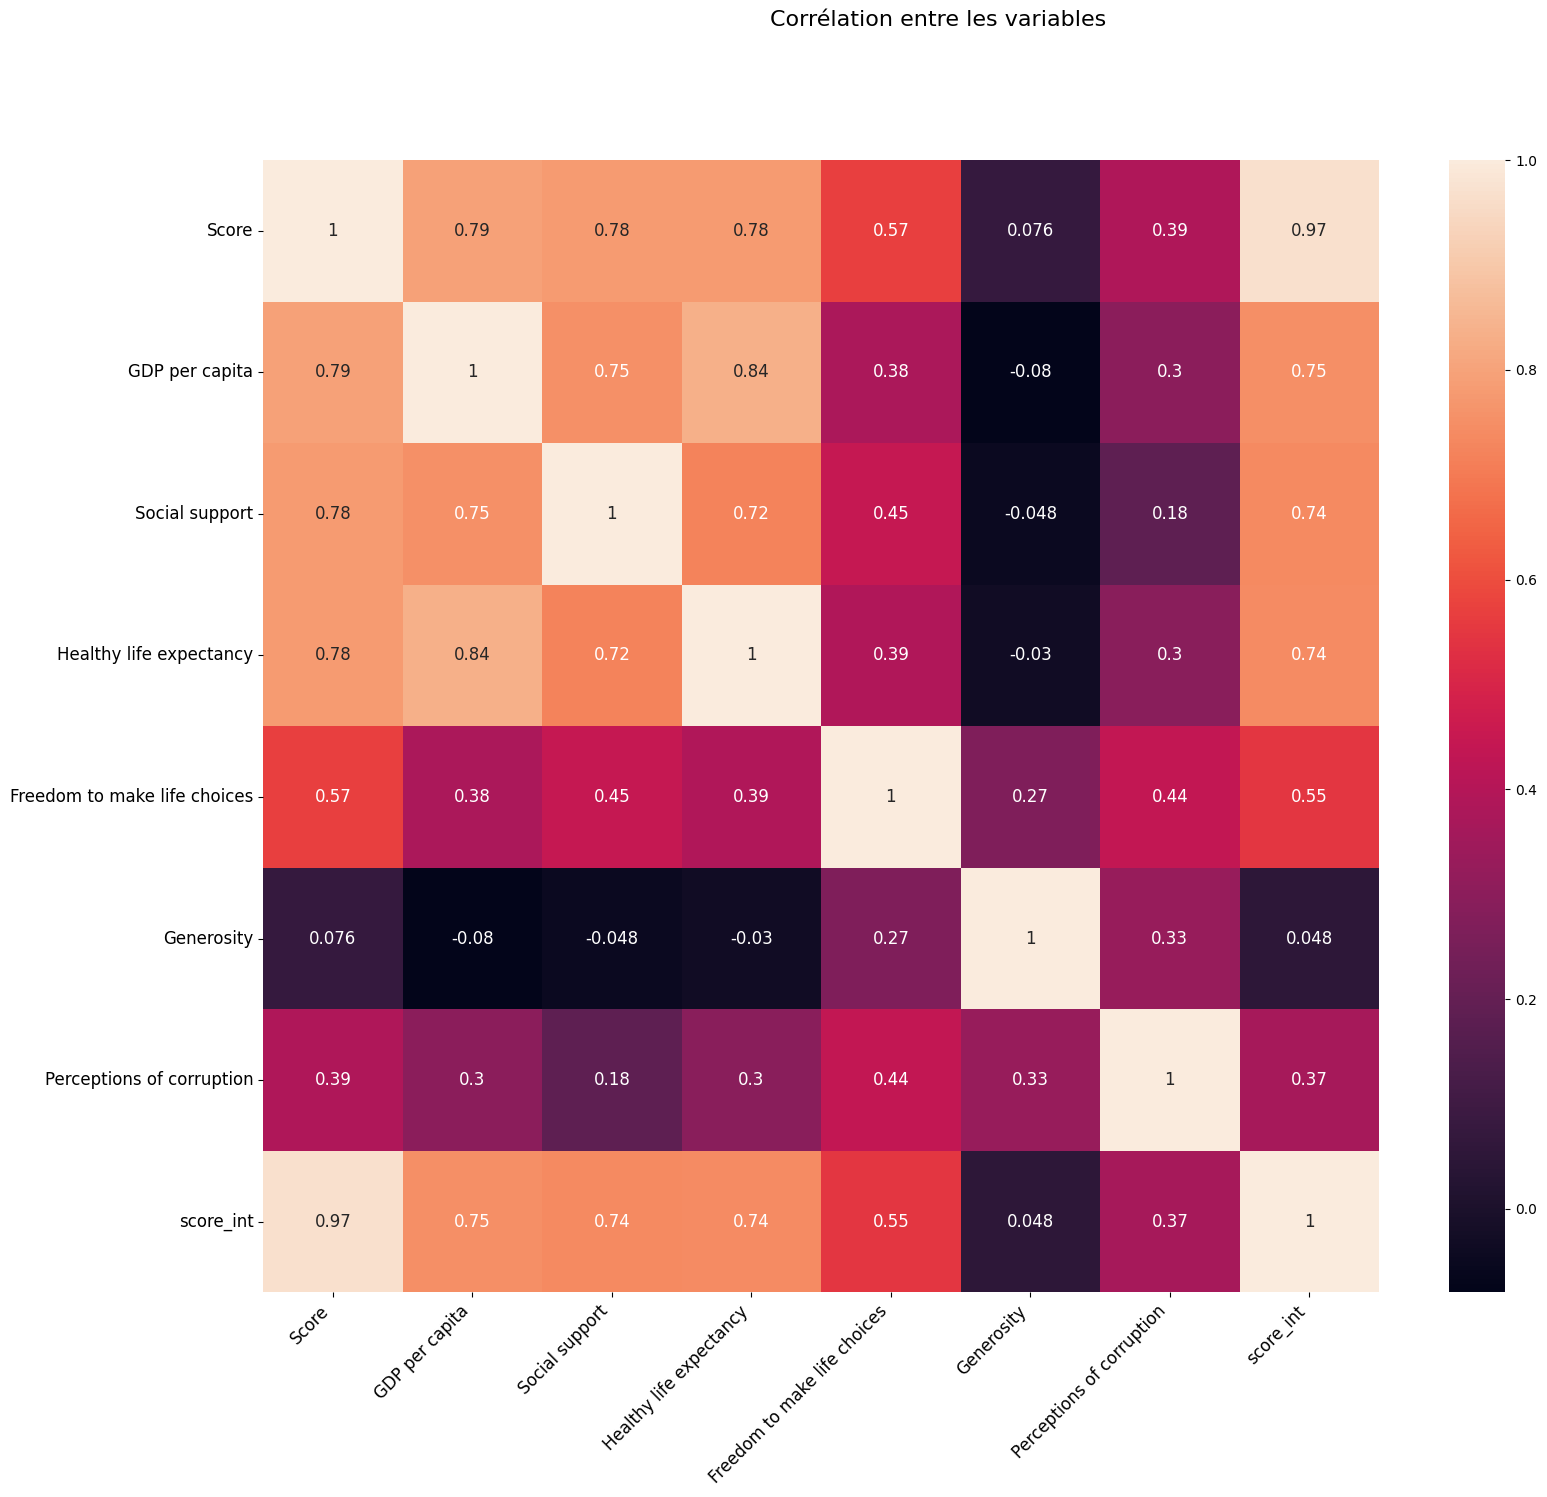

In [15]:
draw_correlation_graphe(df_origine, "Corrélation entre les variables", verbose=verbose,fontsize=12)

<div style="display: flex; background-color: green;" >

## 1.3. Visualisation des outliers
</div>


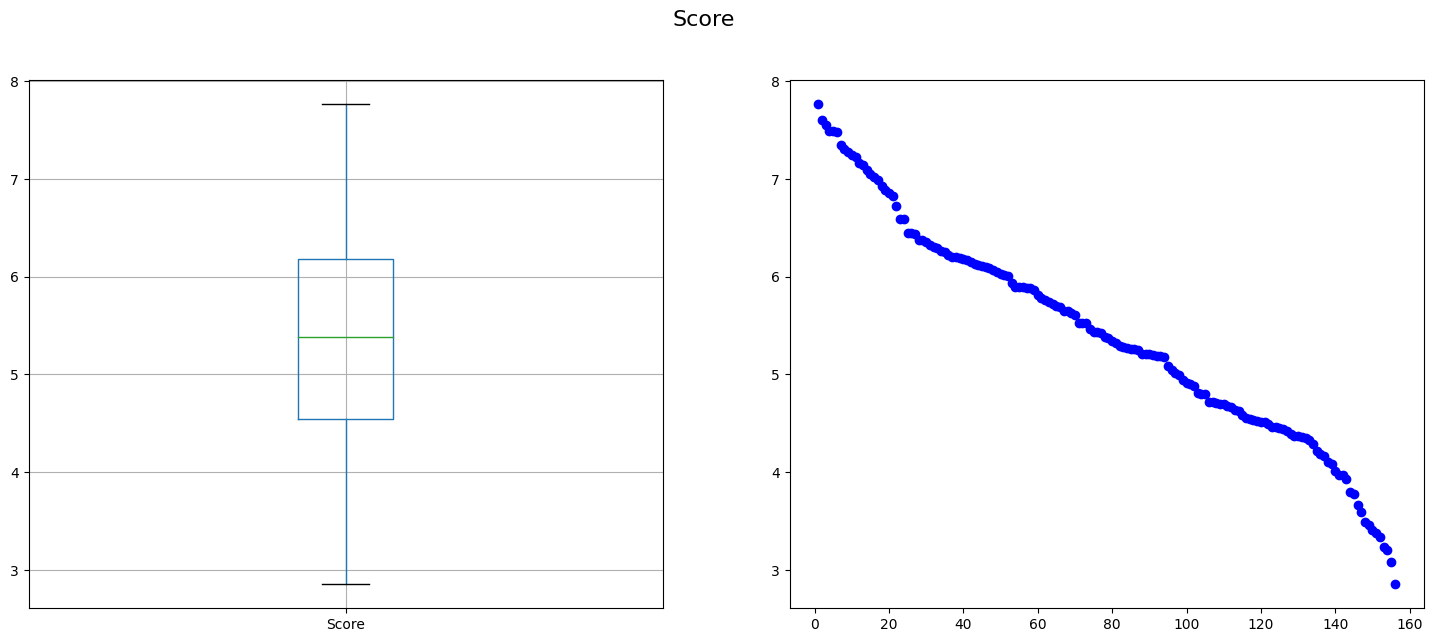

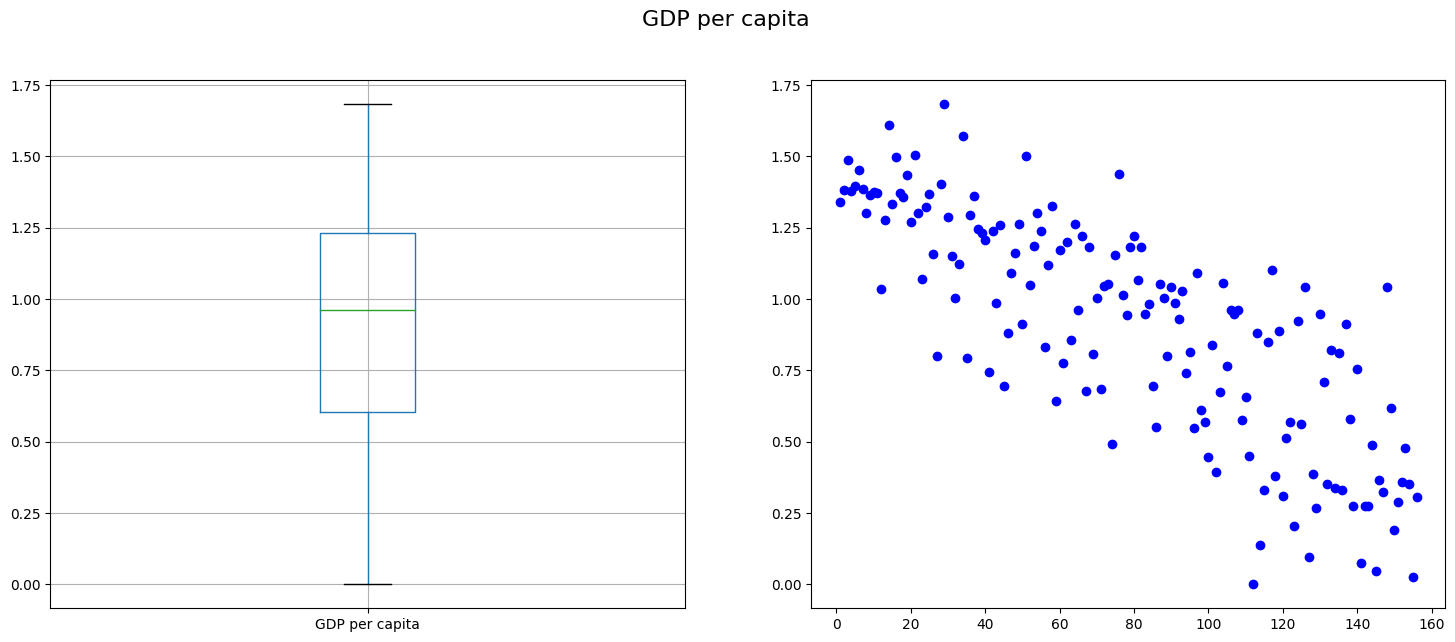

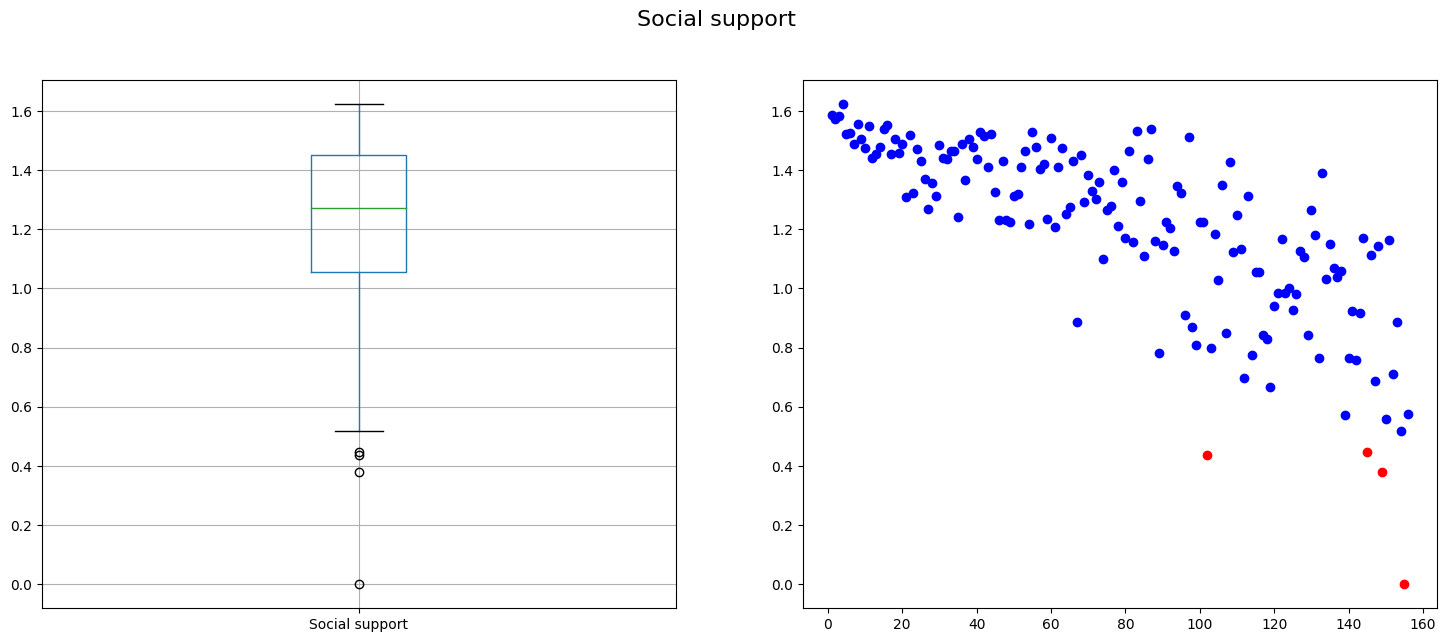

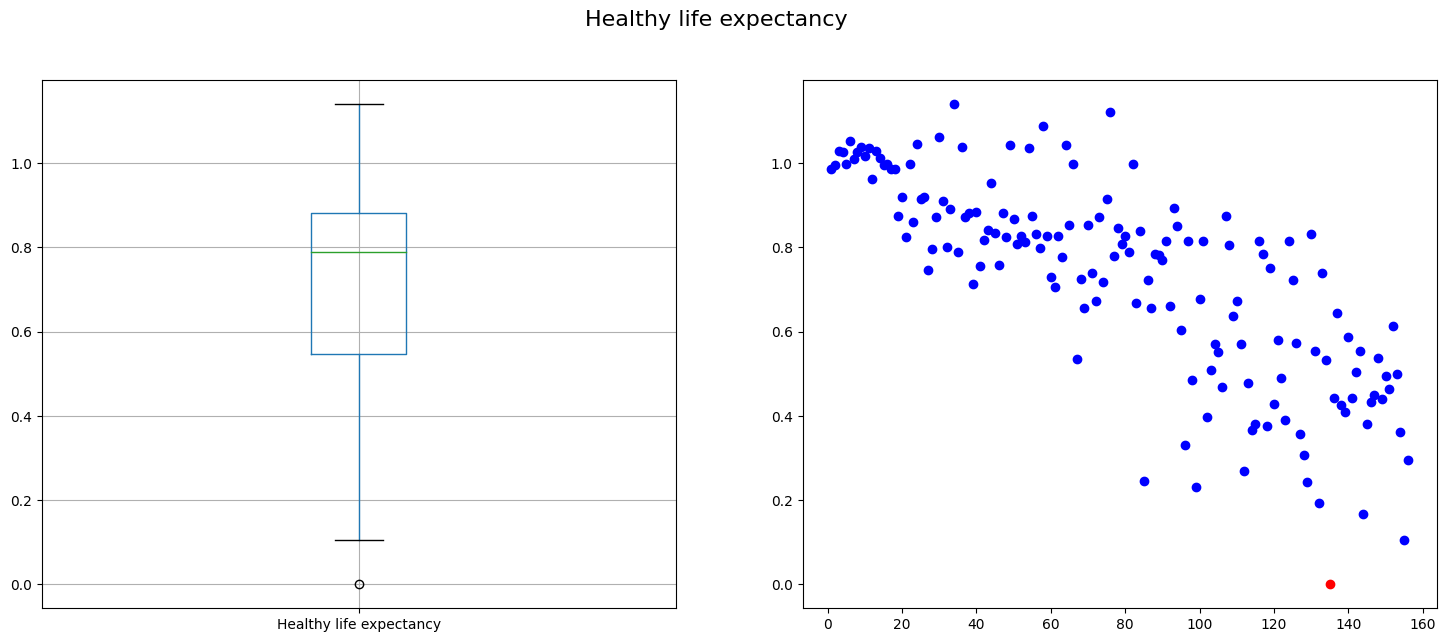

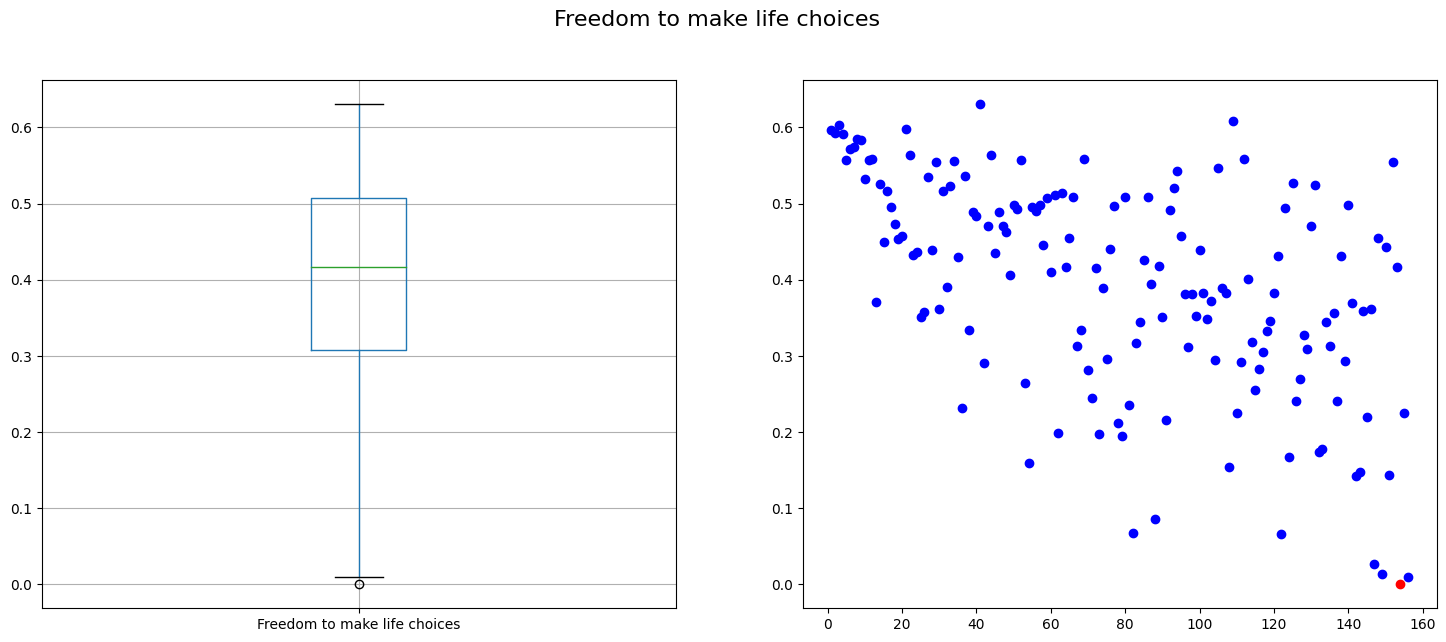

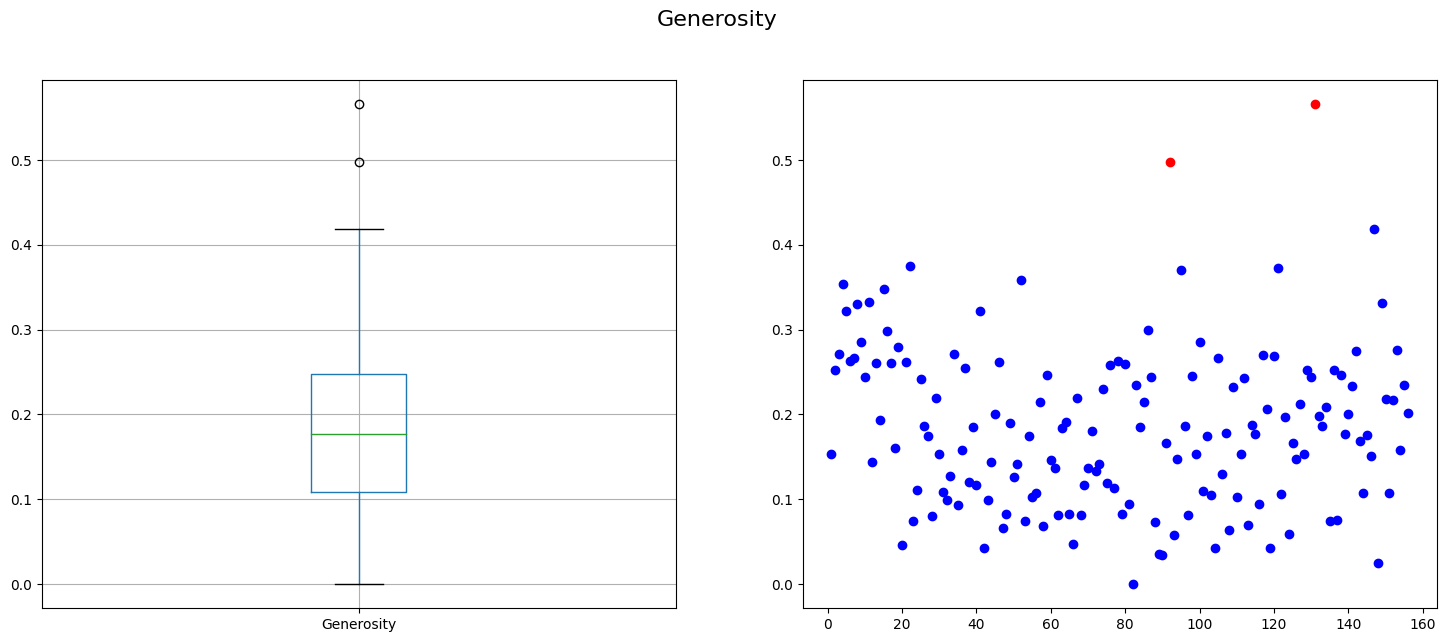

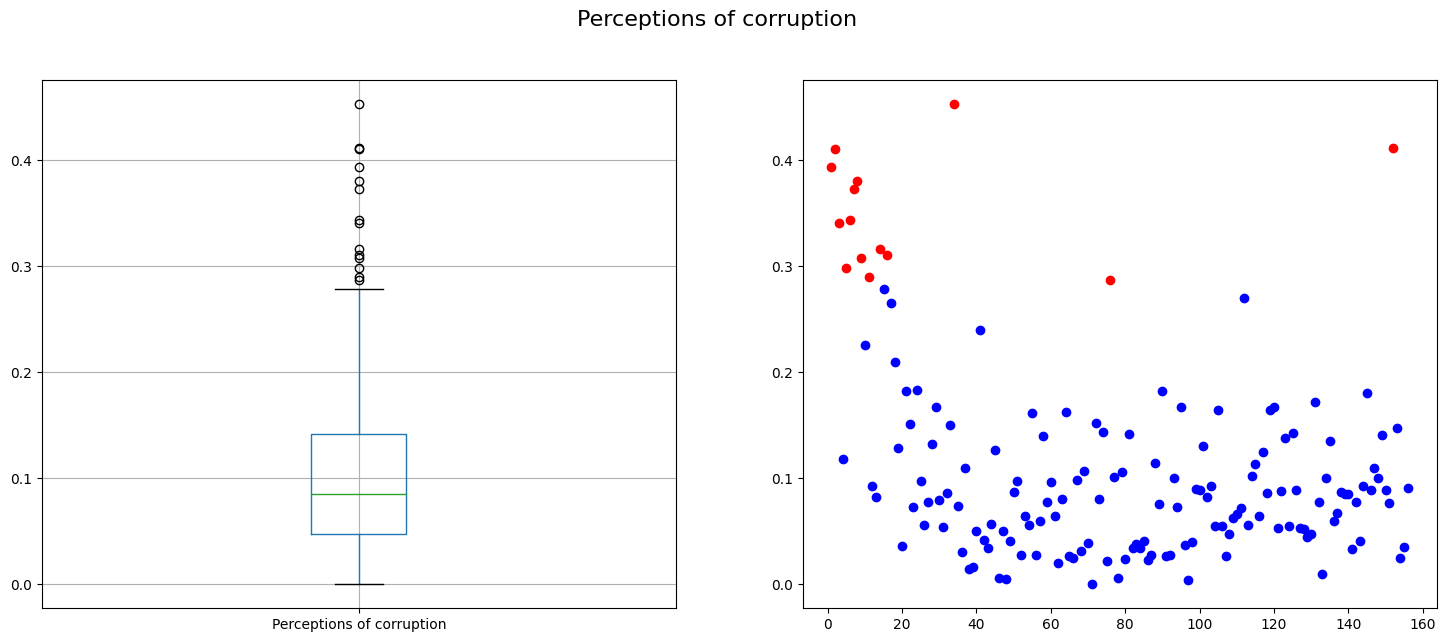

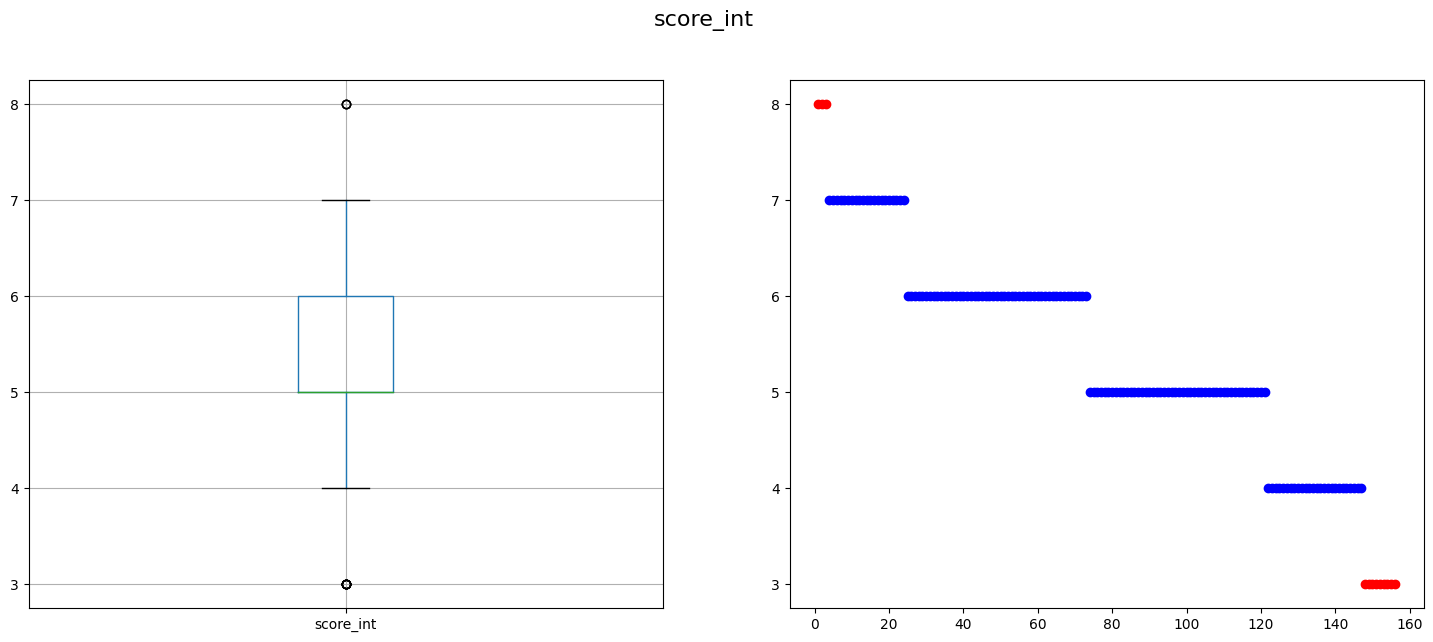

In [16]:
cols = get_numeric_columns_names(df_origine)
for column_name in cols:
    q_low, q_hi,iqr, q_min, q_max = get_outliers_datas(df_origine, column_name)
    graphe_outliers(df_origine, column_name, q_min, q_max)

<div style="display: flex; background-color: green;" >

## 1.4. Analyse des autres doublons possible
</div>



<div style="display: flex; background-color: green;" >

# Chargement DF pays
</div>

In [ ]:
pays_file_name = "data_set_countries_clean.csv"

<div style="display: flex; background-color: Blue; padding: 15px;" >

# K-MEANS
</div>

https://fr.acervolima.com/determination-du-nombre-de-clusters-dans-l-exploration-de-donnees/

<div style="display: flex; background-color: Blue; padding: 15px;" >

# Annexes
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### Titre 2
</div>

<div style="display: flex; background-color: indigo;" >

#### Titre 3
</div>